In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.utils import padding_PSF
from kuaizi.detection import Data
from kuaizi import HSC_pixel_scale, HSC_zeropoint

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file, clear_download_cache

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi.task import hsc_cutout, hsc_psf

s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide')

# Get table list from /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/unagi-0.1.3.dev13-py3.7.egg/unagi/data/s18a_wide/s18a_wide_tables.fits


In [6]:
from kuaizi.mock import Data, MockGal
import galsim

In [7]:
pos_cat = Table.read(
    './Catalog/fake_gal_pos.fits',
    format='fits')
pos_cat.add_column(Column(data=np.arange(0, len(pos_cat), 1)), name='index')

#### Make one example

In [16]:
channels = 'griz'
bkg_id = 0

cutout = [fits.open(f"./Cutout/mock_sample/bkg/MockBkg_{bkg_id:02d}_{band}.fits") for band in channels]
psf_list = [fits.open(f"./Cutout/mock_sample/bkg/MockBkg_{bkg_id:02d}_psf_{band}.fits") for band in channels]

w = wcs.WCS(cutout[0][1].header)

images = np.array([hdu[1].data for hdu in cutout])
masks = np.array([hdu[2].data for hdu in cutout])
variances = np.array([hdu[3].data for hdu in cutout])

psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC

In [173]:
comp1 = {
    'model': galsim.Sersic,
    'model_params': {
        'n': np.random.uniform(low=0.6, high=1.2),
        'half_light_radius': np.random.uniform(low=4, high=8)
    },
    'shear_params': {
        'q': np.random.uniform(low=0.4, high=1),
        'beta': np.random.uniform(low=-90, high=90) * galsim.degrees,
    },
    'sed': np.array([0.11319384, 0.20486748, 0.2387235, 0.2866302]),
#     'n_knots': np.random.randint(0, 20),
#     'knots_frac': 0.1,
    'knots_sed': np.array([0.2866302 , 0.2387235 , 0.20486748, 0.11319384])
}

In [174]:
galaxy = {'comp': [comp1],
          'imag': np.random.uniform(low=18, high=21), # total mag for all components
          'flux_fraction': [1.0]
         }

In [175]:
bkg = Data(images, variances, masks, channels, w, psfs=psf_pad)
mgal = MockGal(bkg)
mgal.gen_mock_lsbg(galaxy)

# Generating mock galaxy.
    - Total components:  1
    - Types:  ['Sersic']
    - Flux fraction:  [1.0]
    - Magnitude in griz:  [20.1, 19.4, 19.3, 19.1]


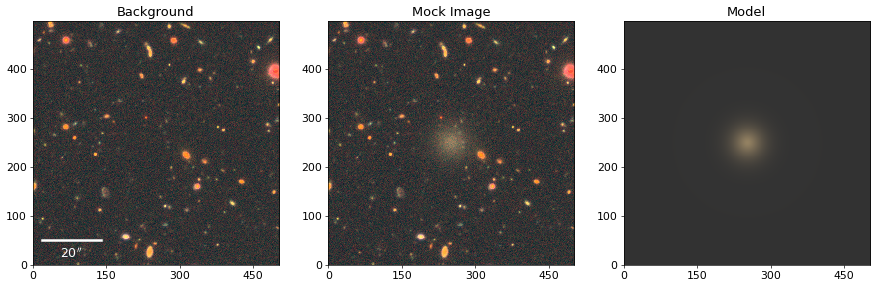

In [176]:
mgal.display()
mgal.write_fits(output_dir='/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/',
                prefix='mock', obj_id=1, overwrite=True)

In [119]:
length = 10

In [239]:
bands = 4
lsbg_cat = Table([Column(name='viz-id', length=length, dtype=int), 
                  Column(name='ra', length=length),
                  Column(name='dec', length=length),
                  Column(name='mag_auto_i', length=length), 
                  Column(name='sersic_n', length=length),
                  Column(name='sersic_ell', length=length),
                  Column(name='sersic_PA', length=length),
                  Column(name='sersic_rhalf_ellip', length=length),
                  Column(name='sersic_sed', length=length, shape=(bands,)),
                  Column(name='mags', length=length, shape=(bands,)), 
                  Column(name='prefix', length=length, dtype='S57'),
                  ])
lsbg_cat

viz-id,ra,dec,mag_auto_i,sersic_n,sersic_ell,sersic_PA,sersic_rhalf_ellip,sersic_sed [4],mags [4],prefix
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes57
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0 .. 0.0,0.0 .. 0.0,


In [237]:
mgal.mock.info['comp'][0]['shear_params']['beta'].deg

-26.264345804546814

In [224]:
mgal.mock.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.8271751257690255,
    'half_light_radius': 2.7634650746886975},
   'shear_params': {'q': 0.689300087896938,
    'beta': coord.Angle(-0.458399310171701, coord.radians)},
   'sed': array([0.57596779, 0.96116646, 1.        , 1.00762928])}],
 'imag': 22.744192108925404,
 'flux_fraction': [1.0],
 'ra': 236.03819636941327,
 'dec': 43.193055463447706,
 'gmag': 23.343196618783626,
 'rmag': 22.78719558731526,
 'zmag': 22.7359401649029}

In [177]:
obj = lsbg_cat[1]
obj['viz-id'] = 1
obj['ra'] = mgal.mock.info['ra']
obj['dec'] = mgal.mock.info['dec']
obj['mag_auto_i'] = mgal.mock.info['imag']
obj['prefix'] = f'/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_{obj["viz-id"]}'

In [178]:
lsbg_cat

viz-id,ra,dec,mag_auto_i,prefix
int64,float64,float64,float64,bytes57
0,235.49609424903161,43.411166287131984,18.529313205086652,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_0
1,235.49609424903161,43.411166287131984,19.268754690699225,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_1
0,0.0,0.0,0.0,
0,0.0,0.0,0.0,
0,0.0,0.0,0.0,
0,0.0,0.0,0.0,
0,0.0,0.0,0.0,
0,0.0,0.0,0.0,
0,0.0,0.0,0.0,


## Generate mock galaxies w.r.t. Greco+18 distribution

In [180]:
# See https://github.com/AstroJacobLi/HSC_LSBG/blob/master/scarlet_LSBG/MockTest/GenMockSersicGalaxy.ipynb

In [8]:
ref_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/Greco_S18A_lsbg.fits')

In [13]:
param_prior = {'n': (3.4785580110015166, 0.15885542469916691, 0.230842124275263),
 'Re': (2.0171562805138388, 2.0475673198750783 - 0.5, 0.8457427201457912 + 0.5),
 'imag': (20.062227912932137 + 1, 0.9688644061107284 - 0.4),
 'q': (0.6949167733674776, 0.15705728417525935)}

Text(0.5, 0, 'Reff (circ)')

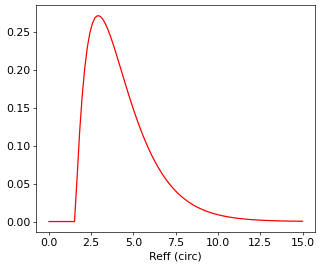

In [14]:
import scipy
x = np.linspace(0, 15, 100)
fitted_data = scipy.stats.distributions.gamma.pdf(x, *param_prior['Re'])

plt.plot(x, fitted_data, 'r-')
plt.xlabel('Reff (circ)')

Text(0.5, 0, 'n')

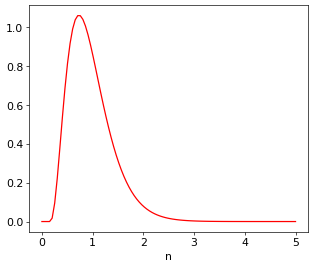

In [17]:
import scipy
x = np.linspace(0, 5, 100)
fitted_data = scipy.stats.distributions.gamma.pdf(x, *param_prior['n'])

plt.plot(x, fitted_data, 'r-')
plt.xlabel('n')

In [18]:
imag = np.random.normal(param_prior['imag'][0], scale=param_prior['imag'][1], size=1000)
n = np.random.gamma(param_prior['n'][0], scale=param_prior['n'][2], size=1000) + param_prior['n'][1]
Re = np.random.gamma(param_prior['Re'][0], scale=param_prior['Re'][2], size=1000) + param_prior['Re'][1]

(array([  7.,  41., 110., 184., 230., 184., 133.,  78.,  24.,   9.]),
 array([22.97490853, 23.60270873, 24.23050892, 24.85830911, 25.48610931,
        26.1139095 , 26.74170969, 27.36950988, 27.99731008, 28.62511027,
        29.25291046]),
 <BarContainer object of 10 artists>)

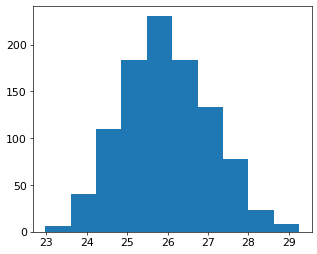

In [20]:
plt.hist(imag + 2.5 * np.log10(2 * np.pi * Re**2))# = mue

In [21]:
output_dir = '/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/'

In [22]:
length = 100
bands = 4
lsbg_cat = Table([Column(name='viz-id', length=length, dtype=int), 
                  Column(name='ra', length=length),
                  Column(name='dec', length=length),
                  Column(name='mag_auto_i', length=length), 
                  Column(name='sersic_n', length=length),
                  Column(name='sersic_ell', length=length),
                  Column(name='sersic_PA', length=length),
                  Column(name='sersic_rhalf_circ', length=length),
                  Column(name='sersic_sed', length=length, shape=(bands,)),
                  Column(name='mags', length=length, shape=(bands,)), 
                  Column(name='prefix', length=length, dtype='S65'),
                  ])

In [23]:
from tqdm import trange

In [25]:
for ind in trange(100, 200):
    bkg_id = np.random.randint(0, 50)

    #### Load bkg ####
    channels = 'griz'
    cutout = [fits.open(f"./Cutout/mock_sample/bkg/MockBkg_{bkg_id:02d}_{band}.fits") for band in channels]
    psf_list = [fits.open(f"./Cutout/mock_sample/bkg/MockBkg_{bkg_id:02d}_psf_{band}.fits") for band in channels]

    w = wcs.WCS(cutout[0][1].header)

    images = np.array([hdu[1].data for hdu in cutout])
    masks = np.array([hdu[2].data for hdu in cutout])
    variances = np.array([hdu[3].data for hdu in cutout])

    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC

    bkg = Data(images, variances, masks, channels, w, psfs=psf_pad)
    
    #### Gen mock gal ####
    q = np.random.normal(param_prior['q'][0], scale=param_prior['q'][1])
    while q > 1 or q < 0.3:
        q = np.random.normal(param_prior['q'][0], scale=param_prior['q'][1]) # q must be less than 1

    imag = np.random.normal(param_prior['imag'][0], scale=param_prior['imag'][1])

    gr = ref_cat[np.argsort(abs(ref_cat['mag_auto_i'] - imag))[0]]['g-r']
    gi = ref_cat[np.argsort(abs(ref_cat['mag_auto_i'] - imag))[0]]['g-i']
    sed = [10**(gi / (-2.5)), 10**(gi / (-2.5))  / 10**(gr / (-2.5)), 1, np.random.uniform(1.0, 1.2)]
    
    n = np.random.gamma(param_prior['n'][0], scale=param_prior['n'][2]) + param_prior['n'][1]
    while n < 0.4:
        n = np.random.gamma(param_prior['n'][0], scale=param_prior['n'][2]) + param_prior['n'][1]

    comp1 = {
        'model': galsim.Sersic,
        'model_params': {
            'n': n,
            'half_light_radius': np.random.gamma(param_prior['Re'][0], scale=param_prior['Re'][2]) + param_prior['Re'][1]
        },
        'shear_params': {
            'q': q,
            'beta': np.random.uniform(low=-90, high=90) * galsim.degrees,
        },
        'sed': np.array(sed),
        #'n_knots': np.random.randint(0, 20),
        #'knots_frac': 0.1,
        #'knots_sed': np.array([0.2866302 , 0.2387235 , 0.20486748, 0.11319384])
    }
    galaxy = {'comp': [comp1],
              'imag': imag, # total mag for all components
              'flux_fraction': [1.0]
             }
    mgal = MockGal(bkg)
    mgal.gen_mock_lsbg(galaxy, verbose=False)
#     mgal.display()
    mgal.write(os.path.join(output_dir, f'mock_{ind}.pkl'), overwrite=True)
    mgal.write_fits(output_dir=output_dir,
                    prefix='mock', 
                    obj_id=ind, 
                    overwrite=True)
    
    obj = lsbg_cat[ind - 100]
    obj['viz-id'] = ind
    obj['ra'] = mgal.mock.info['ra']
    obj['dec'] = mgal.mock.info['dec']
    obj['mag_auto_i'] = mgal.mock.info['imag']
    
    model_dict = comp1
    obj['sersic_n'] = model_dict['model_params']['n']
    obj['sersic_rhalf_circ'] = model_dict['model_params']['half_light_radius']
    obj['sersic_ell'] = 1 - model_dict['shear_params']['q']
    obj['sersic_PA'] = model_dict['shear_params']['beta'].deg
    obj['sersic_sed'] = model_dict['sed']
    obj['mags'] = [mgal.mock.info[f'{filt}mag'] for filt in list('griz')]
    obj['prefix'] = f'/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_{obj["viz-id"]}'

100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

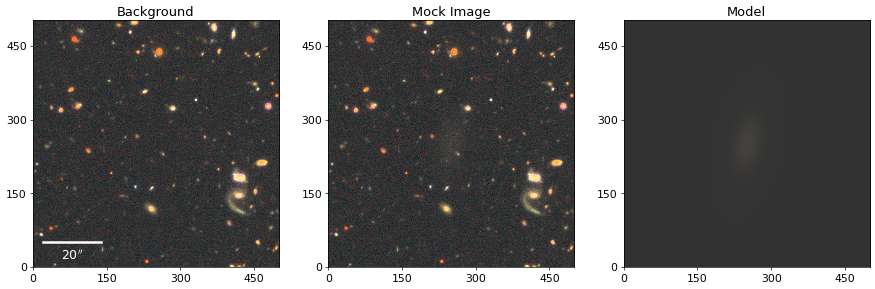

In [26]:
mgal.display()

In [27]:
lsbg_cat['mag_auto_i']

21.886546640786992
21.739598828112317
20.702300908660597
21.10004227549164
21.22578784986791
22.681112724499275
22.158908137938187
20.955660942870235
20.66178356372081
20.59408688059838
21.143406245785886


In [28]:
image_flag = []
for obj in lsbg_cat:
    image_flag.append(
        [os.path.isfile(f"{obj['prefix']}_{filt}.fits") for filt in channels])
lsbg_cat['image_flag'] = image_flag

psf_flag = []
for obj in lsbg_cat:
    psf_flag.append(
        [os.path.isfile(f"{obj['prefix']}_{filt}_psf.fits") for filt in channels])
lsbg_cat['psf_flag'] = psf_flag

In [29]:
lsbg_cat.write('./Catalog/mock_sample/mock_obj_cat_3.fits', overwrite=True)

In [30]:
lsbg_cat

viz-id,ra,dec,mag_auto_i,sersic_n,sersic_ell,sersic_PA,sersic_rhalf_circ,sersic_sed [4],mags [4],prefix,image_flag [4],psf_flag [4]
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes65,bool,bool
100,235.51791400661756,43.73071637581453,21.886546640786992,0.9620752878481641,0.4223670619245884,62.614119732369865,2.2594699862682983,0.3512768240231015 .. 1.104281767224674,23.022422896899762 .. 21.778846886793072,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_100,True .. True,True .. True
101,235.44921642246032,43.47318142932076,21.739598828112317,1.5797878348527028,0.22068577908829834,83.41384250023972,5.9812591501826,0.8279156839266829 .. 1.0608328671863911,21.94463355339024 .. 21.675481411187004,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_101,True .. True,True .. True
102,235.45041589875865,43.73213270597782,20.702300908660597,1.34778350091691,0.23800883596338873,-42.323359143257065,5.155809228787272,0.6276584173261123 .. 1.0823858855261164,21.20799251520019 .. 20.616345607756916,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_102,True .. True,True .. True
103,236.0456163091509,43.632663078136645,21.10004227549164,0.4440171821286166,0.34514814648067504,-3.130513959693033,9.326011952116822,0.5587982779181686 .. 1.014402708337387,21.73190462785885 .. 21.08451627535409,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_103,True .. True,True .. True
104,236.01041613216725,43.684724997443716,21.22578784986791,0.5027602488336804,0.1592749523007423,82.63146716956072,6.912215455834961,0.4335986593297158 .. 1.1394897445059113,22.133068023091244 .. 21.084011797741105,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_104,True .. True,True .. True
105,235.97997034324828,43.21689110378096,22.681112724499275,0.955668311671833,0.4211993581199863,-13.2161034644636,7.038129401372678,0.32874188836247636 .. 1.1733269052482067,23.888975110738603 .. 22.507565150805263,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_105,True .. True,True .. True
106,235.49367717952012,43.96199892368024,22.158908137938187,1.3324194012941235,0.2942105288971435,63.457701267071,5.7084724602945585,0.4934702818229786 .. 1.159793232972401,22.925755629562428 .. 21.99795671181742,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_106,True .. True,True .. True
107,235.6149773518457,43.20825059958027,20.955660942870235,0.7156496537674968,0.5306180470582547,-0.04430632030279469,3.807557355644534,0.3849866923964726 .. 1.1380519005515821,21.992046648440965 .. 20.815255771885205,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_107,True .. True,True .. True
108,236.07951164045699,43.23225115646166,20.66178356372081,0.7706170463904841,0.356718441397733,60.33504552173508,4.177448240137219,0.40925810160674725 .. 1.0083969513716218,21.631790350240983 .. 20.652704753648514,/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/mock_sample/mock_108,True .. True,True .. True


In [2]:
import pickle
with open('./Cutout/mock_sample/mock_58.pkl', 'rb') as fp:
    gal = pickle.load(fp)
    
gal.display()

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

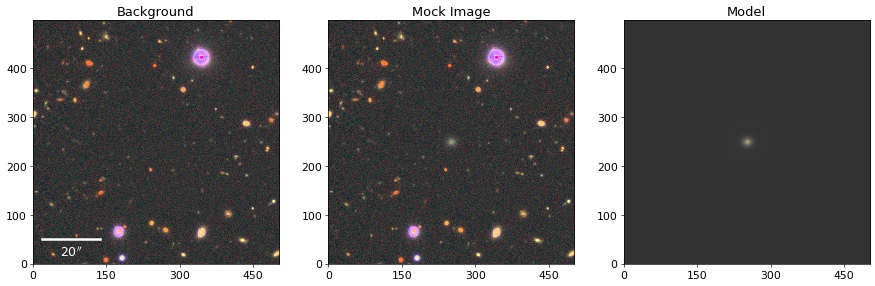